# Distance Matrix Job

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

import numpy as np
import pandas as pd
from surprise import SVD

import util as ut
from domain_context import DomainContext

import api

In [3]:
TEMP_PATH                    = '../../temp'
USER_ITEM_RATING_MATRIX_PATH = f'{TEMP_PATH}/user_item_rating_matrix'
USER_SIMILARITIES_PATH       = f'{TEMP_PATH}/user_similarities.csv'
ITEM_SIMILARITIES_PATH       = f'{TEMP_PATH}/item_similarities.csv'

HOST                         = 'http://localhost:8000'
API_TOKEN                    = 'e3ff025094fe0ee474501bbeda0a2a44e80230c1'

GENERATE_RATING_MATRIX       = True
GENERATE_USER_SIMILARITIES   = True
GENERATE_ITEM_SIMILARITIES   = True

### Setup

In [4]:
!mkdir -p {TEMP_PATH}

In [5]:
ctx = DomainContext(API_TOKEN, HOST)

### Get interactions

2022-12-10 16:38:40,950 [INFO] - Page 1/2 - Interactions 50000/96605
2022-12-10 16:38:43,124 [INFO] - Page 2/2 - Interactions 96605/96605
2022-12-10 16:38:43,125 [INFO] - 96605 Total Interactions 


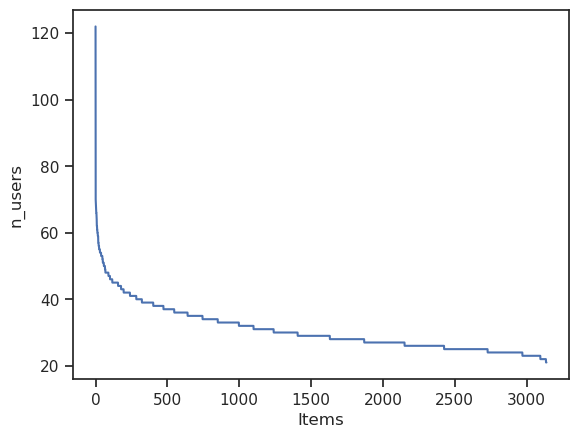

In [6]:
interactions = ctx.interaction_service.find_all()
ctx.interaction_service.plot_n_users_by_item(interactions)

### Compute Rating Matrix

In [7]:
if GENERATE_RATING_MATRIX:
    rating_matrix = ctx.rating_matrix_service.compute(
        interactions, 
        model = SVD()
    )
    ut.Picket.save(USER_ITEM_RATING_MATRIX_PATH, rating_matrix)
else:
    rating_matrix = ut.Picket.load(USER_ITEM_RATING_MATRIX_PATH)

2022-12-10 16:38:43,303 [INFO] Filter by ratings scale: [1, 2, 3, 4, 5]
2022-12-10 16:38:43,309 [INFO] Filtered: 100.0%
2022-12-10 16:38:43,309 [INFO] Filter by user_n_interactions >= 20
2022-12-10 16:38:43,314 [INFO] Filtered: 95.2%
2022-12-10 16:38:57,458 [INFO] Unrated interactions: 97.4%
2022-12-10 16:38:57,573 [INFO] Rating Scale: (1, 5)
2022-12-10 16:38:57,608 [INFO] SVD Training...
2022-12-10 16:39:03,097 [INFO] SVD Ratings Prediction... 5%
2022-12-10 16:39:08,134 [INFO] SVD Ratings Prediction... 10%
2022-12-10 16:39:13,145 [INFO] SVD Ratings Prediction... 15%
2022-12-10 16:39:18,168 [INFO] SVD Ratings Prediction... 20%
2022-12-10 16:39:22,819 [INFO] SVD Ratings Prediction... 25%
2022-12-10 16:39:27,753 [INFO] SVD Ratings Prediction... 30%
2022-12-10 16:39:32,472 [INFO] SVD Ratings Prediction... 35%
2022-12-10 16:39:37,110 [INFO] SVD Ratings Prediction... 40%
2022-12-10 16:39:41,753 [INFO] SVD Ratings Prediction... 45%
2022-12-10 16:39:46,391 [INFO] SVD Ratings Prediction... 50%

In [8]:
!du -h {USER_ITEM_RATING_MATRIX_PATH}.pickle

40M	../../temp/user_item_rating_matrix.pickle


Check matrix data:

In [9]:
# interactions.head(3)

In [10]:
# rating_matrix[98-1, 115-1], rating_matrix[320-1, 115-1], rating_matrix[90-1, 115-1]

In [11]:
# interactions.tail(3)

In [12]:
# rating_matrix[1-1, 16759-1], rating_matrix[1-1, 137181-1], rating_matrix[1-1, 210831-1]

In [13]:
# rating_matrix[98-1].toarray()[0].shape

### Compute User-User and Item-Item similarity matrix

In [14]:
if GENERATE_USER_SIMILARITIES:
    user_similarities = ctx.similarity_service.similarities(
        rating_matrix,
        row_ids   = interactions.user_id.unique(),
        entity    = 'user',
        n_workers = 10,
        chunks    = 10_000
    )
    ut.save(user_similarities, USER_SIMILARITIES_PATH)
else:
    user_similarities = ut.load(USER_SIMILARITIES_PATH) 

2022-12-10 16:42:25,969 [INFO] Compute user_id combinations...
2022-12-10 16:42:26,016 [INFO] user_id combinations...1253736
2022-12-10 16:42:26,017 [INFO] Compute user_id embeddings(size: 224950)...
2022-12-10 16:42:26,831 [INFO] Compute user_id similarities...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1253736/1253736 [27:22<00:00, 763.21it/s]


In [15]:
!du -h {USER_SIMILARITIES_PATH}

24M	../../temp/user_similarities.csv


In [16]:
if GENERATE_ITEM_SIMILARITIES:
    item_similarities = ctx.similarity_service.similarities(
        rating_matrix.transpose(),
        row_ids   = interactions.item_id.unique(),
        entity    = 'item',
        n_workers = 10,
        chunks    = 10_000
    )
    ut.save(item_similarities, ITEM_SIMILARITIES_PATH)
else:
    item_similarities = ut.load(ITEM_SIMILARITIES_PATH)

2022-12-10 17:09:56,402 [INFO] Compute item_id combinations...
2022-12-10 17:09:56,574 [INFO] item_id combinations...4925091
2022-12-10 17:09:56,575 [INFO] Compute item_id embeddings(size: 1617)...
2022-12-10 17:10:08,861 [INFO] Compute item_id similarities...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4925091/4925091 [00:53<00:00, 92663.61it/s]


In [17]:
!du -h {ITEM_SIMILARITIES_PATH}

151M	../../temp/item_similarities.csv


Filter N most similarity users fofr each user (Same for items):

In [18]:
user_most_similarities = ctx.similarity_service.filter_most_similars(
    user_similarities, 
    column = 'user_a', 
    n      = 50
)

2022-12-10 17:11:26,880 [INFO] Filtered: 77925/1253736 (93.8%)


In [19]:
item_most_similarities = ctx.similarity_service.filter_most_similars(
    item_similarities, 
    column = 'item_a', 
    n      = 50
)

2022-12-10 17:11:31,687 [INFO] Filtered: 155675/4925091 (96.8%)


In [20]:
user_similarity_matrix = ctx.api.add_or_get_similarity_matrix(
    'SVD', 
    api.SimilarityMatrixType.USER_TO_USER, 
    'SVD user to user similarity matrix'
)

user_most_similarities = user_most_similarities.rename(columns={'user_a': 'row', 'user_b': 'column'})
user_most_similarities['matrix'] = user_similarity_matrix.id

iterator = ut.DataFramPaginationIterator(
    user_most_similarities,
    page_size=10_000
)

for page in iterator:
    ctx.api.add_similarity_cells(page) 

2022-12-10 17:11:31,717 [INFO] SVD of type SimilarityMatrixType.USER_TO_USER already exists!
2022-12-10 17:11:31,719 [INFO] Page 1/8 - Items 10000/77925
2022-12-10 17:11:36,466 [INFO] Page 2/8 - Items 20000/77925
2022-12-10 17:11:41,236 [INFO] Page 3/8 - Items 30000/77925
2022-12-10 17:11:46,062 [INFO] Page 4/8 - Items 40000/77925
2022-12-10 17:11:50,608 [INFO] Page 5/8 - Items 50000/77925
2022-12-10 17:11:55,257 [INFO] Page 6/8 - Items 60000/77925
2022-12-10 17:11:59,887 [INFO] Page 7/8 - Items 70000/77925
2022-12-10 17:12:04,506 [INFO] Page 8/8 - Items 7925/77925
2022-12-10 17:12:08,297 [INFO] Totals - Pages 8 - Items 77925


In [21]:
item_similarity_matrix = ctx.api.add_or_get_similarity_matrix(
    'SVD', 
    api.SimilarityMatrixType.ITEM_TO_ITEM,
    'SVD item to item similarity matrix'
)

item_most_similarities = item_most_similarities.rename(columns={'item_a': 'row', 'item_b': 'column'})
item_most_similarities['matrix'] = item_similarity_matrix.id

iterator = ut.DataFramPaginationIterator(
    item_most_similarities,
    page_size=10_000
)

for page in iterator:
    ctx.api.add_similarity_cells(page) 

2022-12-10 17:12:08,317 [INFO] SVD of type SimilarityMatrixType.ITEM_TO_ITEM already exists!
2022-12-10 17:12:08,319 [INFO] Page 1/16 - Items 10000/155675
2022-12-10 17:12:12,901 [INFO] Page 2/16 - Items 20000/155675
2022-12-10 17:12:18,023 [INFO] Page 3/16 - Items 30000/155675
2022-12-10 17:12:22,683 [INFO] Page 4/16 - Items 40000/155675
2022-12-10 17:12:27,190 [INFO] Page 5/16 - Items 50000/155675
2022-12-10 17:12:31,730 [INFO] Page 6/16 - Items 60000/155675
2022-12-10 17:12:36,308 [INFO] Page 7/16 - Items 70000/155675
2022-12-10 17:12:40,901 [INFO] Page 8/16 - Items 80000/155675
2022-12-10 17:12:45,363 [INFO] Page 9/16 - Items 90000/155675
2022-12-10 17:12:50,216 [INFO] Page 10/16 - Items 100000/155675
2022-12-10 17:12:54,902 [INFO] Page 11/16 - Items 110000/155675
2022-12-10 17:12:59,689 [INFO] Page 12/16 - Items 120000/155675
2022-12-10 17:13:04,470 [INFO] Page 13/16 - Items 130000/155675
2022-12-10 17:13:09,177 [INFO] Page 14/16 - Items 140000/155675
2022-12-10 17:13:13,952 [INFO